# PytzMLS2018: Lab 3: Deep learning for computer vision

<center>**Anthony Faustine (sambaiga@gmail.com)**</center>


## Import all necessary libries and modules we will use

In [1]:
import sys
sys.path.append('../src')
import numpy as np
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets, models, transforms
from torch.autograd import Variable
import torch.nn.functional as F
import time
import copy
from ploting import *
import PIL
%matplotlib inline

In [2]:
SEED = 1080
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)

## Part 1. Convolutional Neural Network

**Learning goal**: How to implement a CNN using PyTorch. In this lab we will train a CNN using PyTorch. 


**Task**: Build CNN image classifier to recognize handwritten digits using the MNIST dataset. MNIST contains 70,000 images: 60,000 for training and 10,000 for testing. The images are grayscale, 28x28 pixels, and centered to reduce preprocessing and get started quicker. 

** Procedure**

1. Load the training and test datasets using DataLoader
2. Define a Feedforwad Neural Network
3. Define a loss function
4. Train the network on the training data
5. Test the network on the test data


### 1.1 Load dataset

We will use DataLoader and TensorDataset (from torch.utils.data) for convinience in data handling. You can create your custom dataset class by inheriting Dataset with some required member functions.

The output of torchvision datasets are PILImage images of range [0, 1]. We transform them to Tensors of normalized range [-1, 1]

In [3]:
train_dataset = datasets.MNIST(root='../data/mnist', 
                            train=True, # this is training data
                            transform=transforms.ToTensor(),# Converts a PIL.Image or numpy.ndarray to
                                                           # torch.FloatTensor of shape (C x H x W) and normalize in the range [0.0, 1.0]
                            download=True)

test_dataset = datasets.MNIST(root='../data/mnist', 
                           train=False, 
                           transform=transforms.ToTensor())

### 1.1.1 Make iteratable data loader

In [4]:
batch_size = 32


train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

### 1.1.2  Visualize train dataset


Let's inspect a few examples. The MNIST dataset contains only grayscale images. For more advanced datasets, we'll have the three color channels (RGB).

Let us check the shape of the image

In [5]:
train_dataset.train_data[1].shape

torch.Size([28, 28])

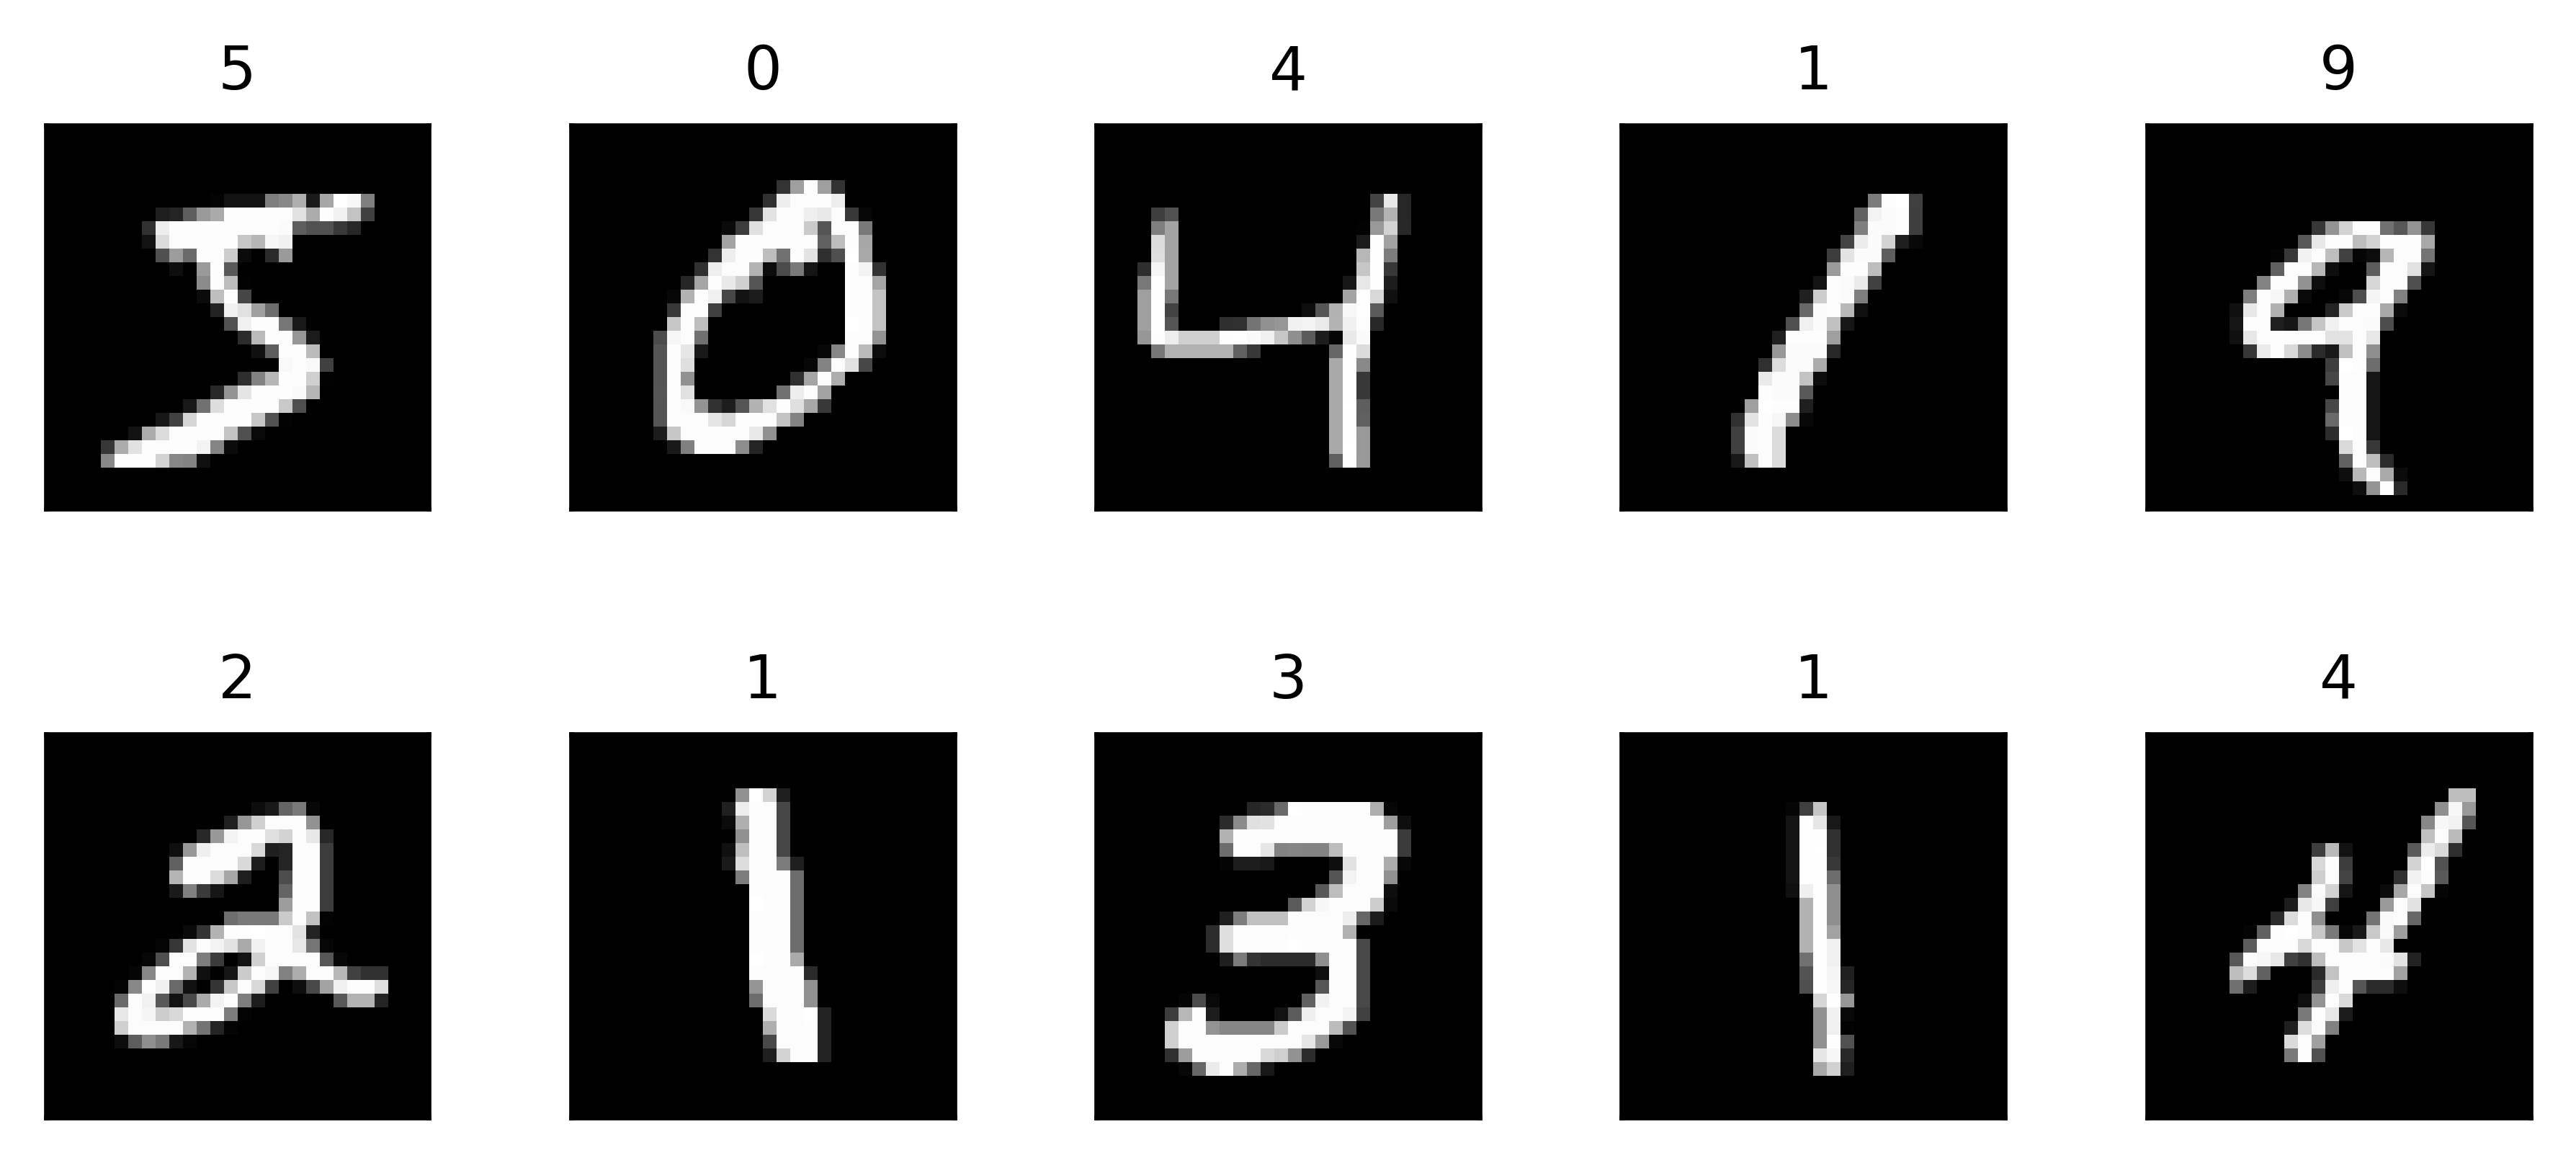

In [6]:
#plt.figure(figsize=(12,10))
beatify(fig_width=6)
fig, axs = plt.subplots(2,5,)
fig.subplots_adjust(hspace = 0.5, wspace=.1)
axs = axs.ravel()

for i in range(10):
    axs[i].imshow(train_dataset.train_data[i].numpy(), cmap='gray', interpolation='none')
    axs[i].set_title('%i' % train_dataset.train_labels[i], fontsize=10)
    plt.tight_layout()
    axs[i].set_xticks([])
    axs[i].set_yticks([])

### 1.2. Define  CNN model

In this step we define CNN model in which a key module for constructing a convolutional net is nn.ConvXd. Although we use 2-dimensional convolution layer, parameters are almost same for all X-dimensional convolution layers. You need to specify the number of input channels (in_channels), the number of output channels (out_channels), the kernel (filter) size (kernel_size), stride size (stride), zero-padding (padding), and so forth as discussed in the tutorial.

We will use 2 convolution layers with max pooling and they are followed by 3 fully-connected layers with RELU activation. We do not apply any activation at the output layer to use activation-combined loss function for a better numerical stability. The network is shown below:

<img src="../data/images/Conv1.png" width="100%">


**Conv1**:
- in_channel (D) = 1 (since the image is Grey scale)
- out_chabbel (K) = 32
- Filter_size (F) = 3

self.conv1 = nn.Conv2d(1, 32, 3)

**MaxPool**:
- Filter size (F)=2
- Stride (S)=2
self.pool = nn.MaxPool2d(2, 2)

**Conv2**:
- in_channel (D) = 32 (output_channel of Conv1)
- out_chabbel (K) = 64
- Filter_size (F) = 3
- self.conv2 = nn.Conv2d(32, 64, 3)


**Questions**
1. What is the purpose of pooling layer?
2. What is the output size of conv1 and conv2?
3. What is the output size of MaxPool layer 1 and MaxPool layer 2?
4. Show that the input dimension of FC1 is $5\times 5\times 64$

In [7]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.fc1 = nn.Linear(64*5*5, 10, bias=True)
       


    def forward(self, x):
        out  = F.relu(self.conv1(x))
        out  = self.pool(out)
        out  = F.relu(self.conv2(out))
        out = self.pool(out)
        out = out.view(out.size(0), -1) 
        out = self.fc1(out)
        return out

In [8]:
model = CNN()
print(model)

CNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=1600, out_features=10, bias=True)
)


### 1.3. Define a Loss function and Optimizer¶

Since this is multi-class classification we will use **Cross Entropy loss**. PyTorch provide **Cross Entropy loss**  loss function which combines a softmax layer and the **Cross Entropy loss** together and it is more numerically stable than using them separately. Thus it is why we didnt  apply softmax activation after the output layer while defining MLP model. See the last model definition above.

We will use SGD with momentum as our optimizer. When we create an optimizer in PyTorch, we need to pass parameters that we want to optimize (train) as input arguments. We can retrieve all trainable parameters of the model by calling **model.parameters()**.

**Questions**
1. Write an expression of a softmax function.
2. What are the advantage of using SGD with momentum in training neural network?

In [9]:
learning_rate = 0.001
criterion = nn.CrossEntropyLoss()
optimizer =  torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

### 1.4. Train the network
Now, we need to train the model. For each full coverage of train dataset, we just need to do a forward pass computation with a mini-batch of dataset and a backward pass to compute gradients followed by a step of optimization. We need to do this for a reasonable number of iterations.

In [10]:
def train(model, optimizer, num_epochs):
    
    
    total_loss = []
    print("Start training")
    
    for epoch in range(num_epochs):
        
        training_loss = []
        
        model.train()
        
        for i, (images, labels) in enumerate(train_loader):
            images = Variable(images)
            labels = Variable(labels)
        
            # Clear gradients w.r.t. parameters
            optimizer.zero_grad()
        
            # Forward pass to get output/logits
            outputs = model(images)
        
            # Calculate Loss: softmax --> cross entropy loss
            loss = criterion(outputs, labels)
            training_loss.append(loss.data[0])
        
            # Getting gradients w.r.t. parameters
            loss.backward()
        
            # Updating parameters
            optimizer.step()
        
            # print statistics
            # print statistics
           
            if i %4000 == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.4f}'.format(
                epoch+1, i * len(images), len(train_loader.dataset),
                100. * i / len(train_loader), np.mean(training_loss)))
             
              
        total_loss.append(np.mean(training_loss))     
        
       
    return total_loss    
          

In [ ]:
total_loss = train(model, optimizer, 5)

Start training
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.2907
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.2159


### 1.4.1 Visualize training loss

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(total_loss, label="rate={}".format(learning_rate))
plt.title("Training Loss")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()

### 1.5 Test the network on the test data

In [ ]:
def test(model):
    
    model.eval()
    
    correct = 0
    predictions=[]
    ground_t=[]
    
    for i, (images, labels) in enumerate(test_loader):
        images = Variable(images)
        labels = Variable(labels)

        outputs = model(images)
        
        # Get predictions from the maximum value
        _, pred = torch.max(outputs.data, 1)
        predictions  += pred.numpy().tolist()
        ground_t+= labels.data.numpy().tolist()
        #correct += pred.eq(labels.data.view_as(pred)).cpu().sum()
        correct += torch.sum(pred == labels.data)
    
    print('')
    predictions = np.array(predictions)
    ground_t    = np.array(ground_t)   
    accuracy = 100. * correct / len(test_loader.dataset)
        
    print("Accuracy: {}%".format(accuracy))
    
    return ground_t, predictions
    

In [ ]:
ground_t, predictions = test(model)

### 1.5.1 VIsualize Results

In [ ]:
correct_indices = np.nonzero(predictions == ground_t)[0]
incorrect_indices = np.nonzero(predictions != ground_t)[0]
print()
print(len(correct_indices)," classified correctly")
print(len(incorrect_indices)," classified incorrectly")

** Qustion**
1. How does this result compare with the MLP case?

#### 1.5.1.1 Visualize correct prediction

In [ ]:
#plt.figure(figsize=(10,6))
indices = np.random.permutation(correct_indices)
figure_evaluation = plt.figure()

# plot 9 correct predictions
for i, correct in enumerate(indices[:9]):
    plt.subplot(6,3,i+1)
    plt.imshow(test_dataset.test_data[correct].numpy(),  cmap='gray', interpolation='none')
    plt.title("Predicted {}, Actual {}".format(predictions[correct], ground_t[correct]))
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

#### 1.5.1.2 Visualize incorrect prediction

In [ ]:
indices = np.random.permutation(incorrect_indices)
figure_evaluation = plt.figure()

# plot 9 correct predictions
for i, correct in enumerate(indices[:9]):
    plt.subplot(6,3,i+1)
    plt.imshow(test_dataset.test_data[correct].numpy(), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Actual {}".format(predictions[correct], ground_t[correct]))
    plt.xticks([])
    plt.tight_layout()
    plt.yticks([])

## Part 2 Transfer learning

**Transfer learning**  is a machine learning method where a model developed for a task is reused as the starting point for a model on a second task.

It is a popular approach in deep learning where pre-trained models are used as the starting point on computer vision and natural language processing tasks given the vast compute and time resources required to develop neural network models on these problems and from the huge jumps in skill that they provide on related problems.

**Why Transfer Learning?**
- In practice, very few people train an entire CNN from scratch (with random initialization), because it is relatively rare to have a dataset of sufficient size. Instead, it is common to pretrain a ConvNet on a very large dataset (e.g. ImageNet, which contains 1.2 million images with 1000 categories), and then use the ConvNet either as an initialization or a fixed feature extractor for the task of interest.

- Very Deep Networks are expensive to train. The most complex models take weeks to train using hundreds of machines equipped with expensive GPUs.For example, training ResNet18 for 30 epochs in 4 NVIDIA K80 GPU took us 3 days. Training ResNet152 for 120 epochs in the same GPUs takes 4 months.
- Determining the topology/flavour/training method/hyper parameters for deep learning is a black art with not much theory to guide you.

"DON'T TRY TO BE AN HERO" ~Andrej Karapathy


### Transfer learning Strategies:

In general, there are two strategies to perform transfer learning,

 **Finetuning**: consists of using the pretrained network on the base dataset and train all layers in the target dataset. The startegy is useful when the new dataset is large and very different from the original dataset. Since you have large dataset, you can design your own network or use the existing ones. Train the network using random initialisations or use the pre-trained network weights as initialisers. The second one is generally preferred.
 
If the new dataset is small but very different from the original dataset you will need  to extract the features from the earlier layer and train a classifier on top of that. To achieve this you will need to add a few FC layers and output layer, set the weights for earlier layers and freeze them and then train the network. 


 **Freeze all layer except the final one**: which consists of leaving all but the last layer frozen (the weights are not updated) and train the last layer. Here, we will freeze the weights for all of the network except that of the final fully connected layer. This last fully connected layer is replaced with a new one with random weights and only this layer is trained. This strategy is useful if the new dataset is small and similar to original dataset.
 
Pytorch Implementation

```python
for params in model_.parameters():
    params.requires_grad = False 
```    

**Freezing the first few layers**: In this case you will need to freeze the first few layers and train the network.This strategy is useful if the new dataset is larger and similar to original dataset. 

Pytorch implementation freezing the first 5 layers 

```python
ct = 0
for name, child in model.named_children():
    ct += 1
    if ct < 7:
        for name2, params in child.named_parameters():
        params.requires_grad = False         
```            

### 2. 1 Transfer learning 1: Build a classifier for detecting ants and bees

**Learning goal**: How to implement a Transfer learning using PyTorch.



**Task**: Build CNN image classifier to classifiy ants and bees. The dataset have about 120 training images each for ants and bees. There are 75 validation images for each class. Usually, this is a very small dataset to generalize upon, if trained from scratch. Since we are using transfer learning, we should be able to generalize reasonably well.

** Procedure**

1. Download dataset and perform data augementation.
2. Load and define models for transfer learning

#### 2.1.1 Download dataset and perform data augementation

Download the dataset from this [link](https://download.pytorch.org/tutorial/hymenoptera_data.zip). For this lab the data can be found in `../data/hymenoptera/` directory.

In [7]:
PATH = "../data/hymenoptera/"

The data directory should contain train and valid directories. The train and val directory have subdirs for each class you wish to recognize (in this case, 'beens' and 'ants'). we can verify if these directory are present in the defined PATH.

In [8]:
import os
os.listdir(PATH)

['val', 'train']

To view sub-directory in valid folder

In [9]:
os.listdir(f'{PATH}val')

['ants', 'bees']

We can also view some files in this directory

In [10]:
files = os.listdir(f'{PATH}val/bees')[:5]
files

['936182217_c4caa5222d.jpg',
 '348291597_ee836fbb1a.jpg',
 '272986700_d4d4bf8c4b.jpg',
 '2506114833_90a41c5267.jpg',
 '2709775832_85b4b50a57.jpg']

In [11]:
from PIL import Image
image = Image.open(f'{PATH}val/bees/{files[0]}')
image.show()

### Task: 
- Visualize few images for ants in train directory
- What is the size, mode and format of these image?

#### Data Augementation
Data augmentation is a process where you make changes to existing images like adjusting the colors , flipping it horizontally or vertically , scaling , cropping and many more. Pytorch provides a very useful library called `torchvision.transforms` which provides a lot of methods which helps to apply data augmentation. transforms comes with a `compose` method which takes a list of transformation. The pre-trained models expect input  mini-batches of 3-channel RGB images of shape (3 x H x W), where H and W are expected to be at least 224. The images have to be loaded in to a range of [0, 1] and then normalized using mean=[0.485, 0.456, 0.406] and std=[0.229, 0.224, 0.225]

First we create a `transform` object that transform for train and test images:

- For train images resize  image to 244 size by croping to random size and aspect ratioin order to ensure that the training runs quickly, horizontally flip the given image randomly with a given probability (default p=0.5) and transform to tesnsor and finalize normalize the image.

- For valid images we resize  image to 256, crops at the center to 224, transform to tensor and finalize normalize the image.

In [12]:
transform = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
}

In [13]:
image_datasets = {x: datasets.ImageFolder(os.path.join(PATH, x),transform[x]) for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=4) 
               for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes
print(class_names)

['ants', 'bees']


### Visualize a few images after transformation

Let’s visualize a few training images so as to understand the data augmentations.

In [14]:
def inverse_transform(inp):
    
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    
    return inp
    

In [18]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inverse_transform(inp)
    plt.imshow(inp)
    if title is not None:
        plt.title(title, fontsize=10)
    plt.axis('off')

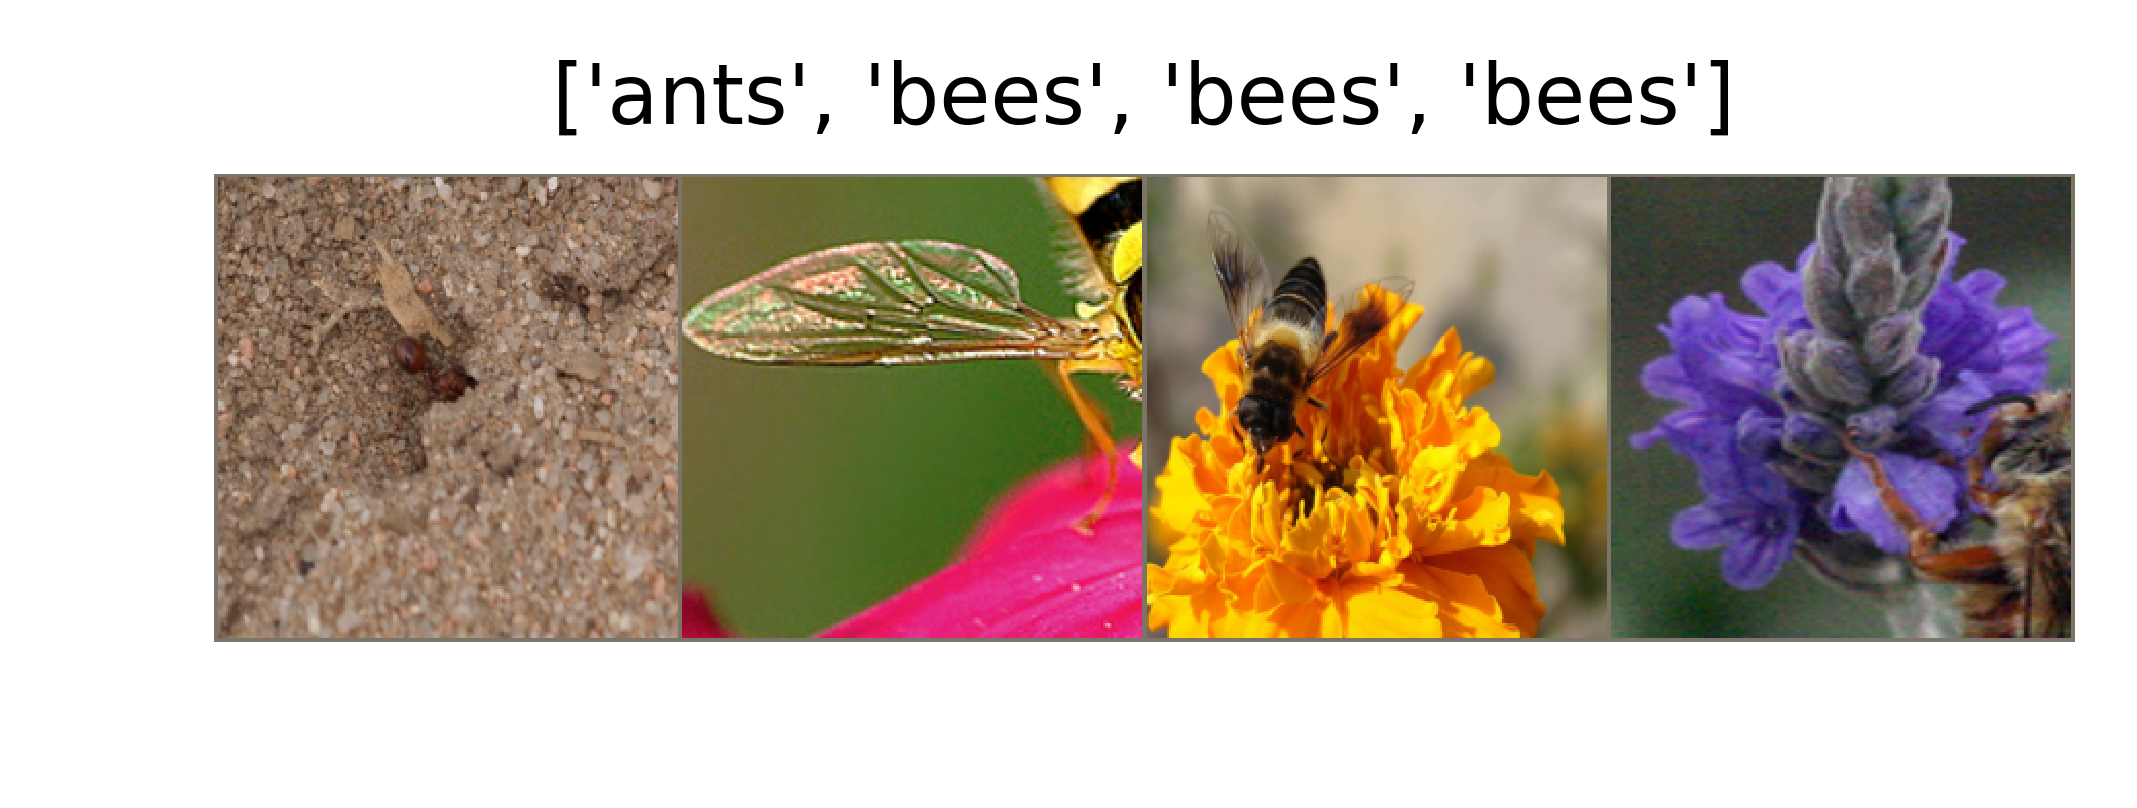

In [19]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

beatify(fig_width=4)
imshow(out, title=[class_names[x] for x in classes])

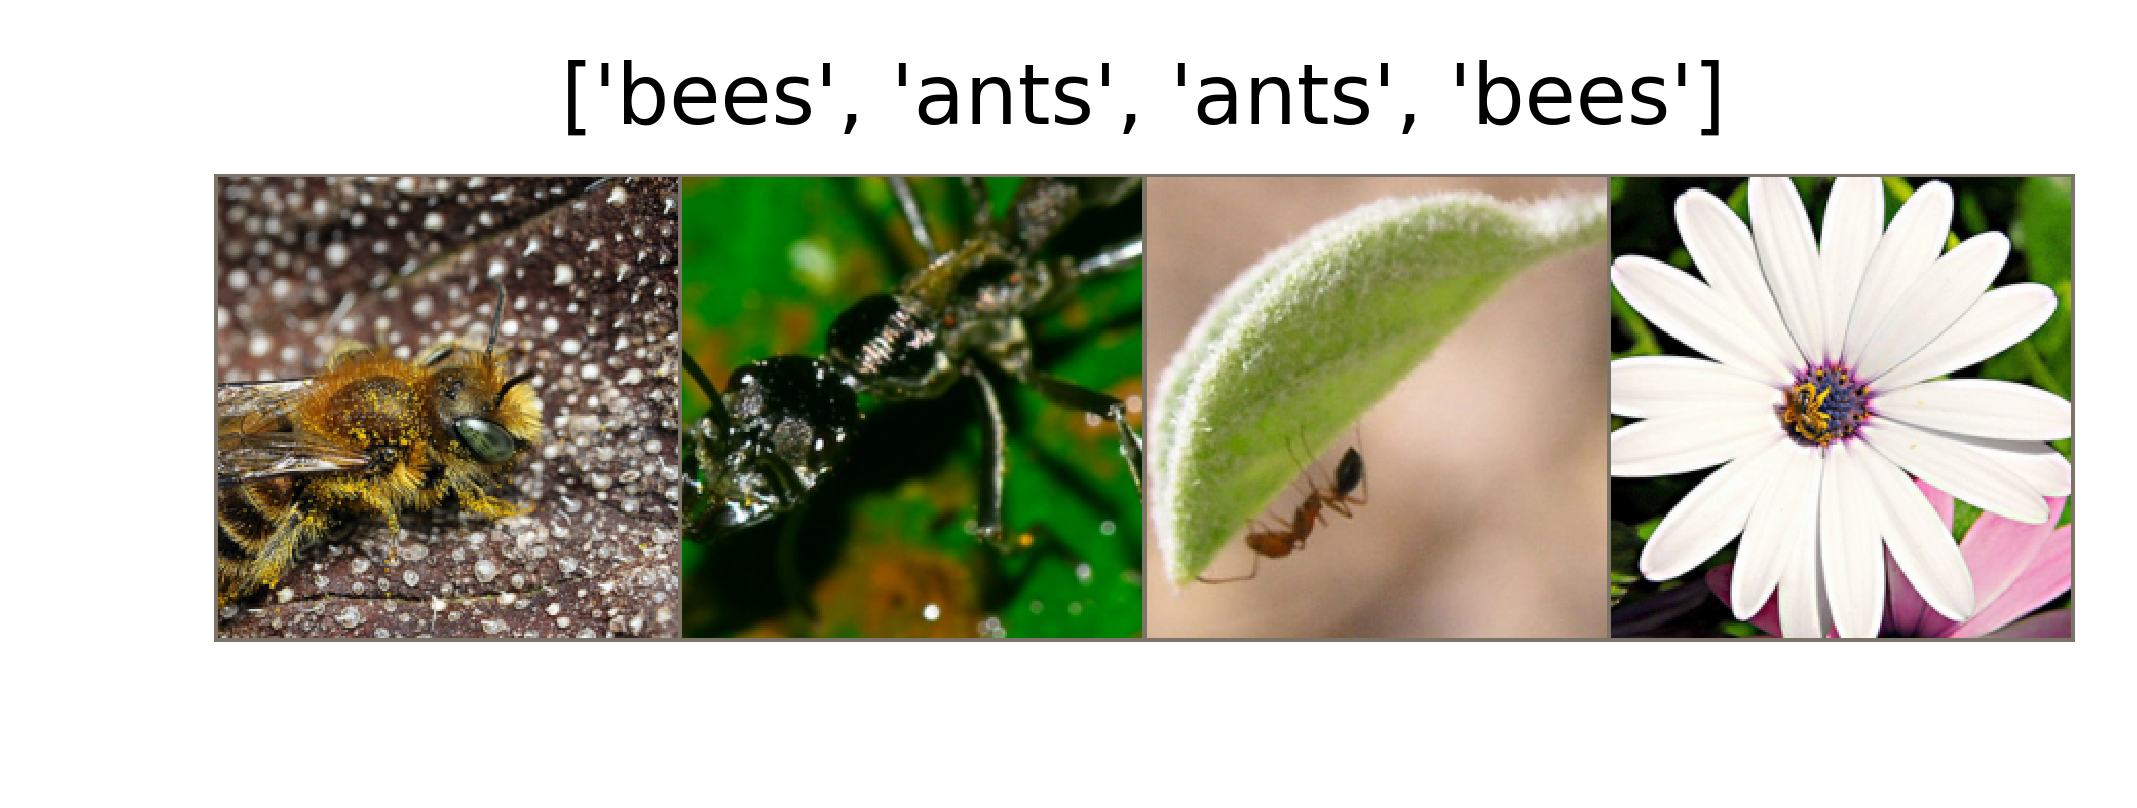

In [20]:
inputs, classes = next(iter(dataloaders['val']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

beatify(fig_width=4)
imshow(out, title=[class_names[x] for x in classes])

### 2.1.2 Load and define models for transfer learning: Finetuning the convnet



We will use a model called [**ResNet**](https://towardsdatascience.com/an-overview-of-resnet-and-its-variants-5281e2f56035) from Microsoft which won the ImageNet competition in 2015. The ResNet model compromises of a bunch of ResNet blocks(Combination of convolution and identity block) and a fully connected layer. The model is trained on Imagenet dataset on 1000 categories , we will remove the last fully connected layer and add a new fully connected layer which outputs 2 categories which tells the probability of the image being Ant or Bee. For this problem we will use finetuning strategies.

#### Load a pretrained model and reset final fully connected layer.

In [21]:
model_resnet18 = models.resnet18(pretrained=True)
print(model_resnet18)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1), ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (b

We use Resnet18 here. If you have more computational power, feel free to swap it with Resnet50, Resnet100 or Resnet152. Since we are doing fine-tuning, or transfer learning we will use the pretrained net weights. 

In [22]:
# get number of feature from the final FC layer
num_features = model_resnet18.fc.in_features

Since imagenet as 1000 classes , We need to change our last layer according to the number of classes we have

In [23]:
#define FC layer with two output category
model_resnet18.fc = nn.Linear(num_features, 2)

### 2.1.2.1 Define loss function and Optimizer

In [24]:
criterion = nn.CrossEntropyLoss()   

In [25]:
optimizer_rst18 = torch.optim.SGD(model_resnet18.parameters(), lr=0.001, momentum=0.9)

### Decaying  Learning rate
Most of the times we start with a higher learning rate so that we can reduce the loss faster and then after a few epochs you would like to reduce it so that the learning becoming slower. `torch.optim.lr_scheduler` provides several methods to adjust the learning rate based on the number of epochs. The `StepLR` function sets the learning rate of each parameter group to the initial lr decayed by gamma every step_size epochs. When last_epoch=-1, sets initial lr as lr.

In [26]:
from torch.optim import lr_scheduler
# Decay LR by a factor of 0.1 every 2 epochs
scheduler_lr = lr_scheduler.StepLR(optimizer_rst18 , step_size=5)

Check if cuda availabe and change the model and criterion to cuda()

In [27]:
if torch.cuda.is_available():
    model_resnet18 = model_resnet18.cuda()
    criterion = criterion.cuda()

### 2.1.2.2 Training the model
Now, let's write a general function to train a model. Here, we will illustrate. The function will Schedule the learning rate and save the best model.

In [28]:
def fit_model(model, criterion, optimizer, scheduler, dataloaders, num_epochs=25):
    
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for data in dataloaders[phase]:
                # get the inputs
                inputs, labels = data

                # wrap them in Variable
                if torch.cuda.is_available():
                    inputs = Variable(inputs.cuda())
                    labels = Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # statistics
                running_loss += loss.data[0] * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [31]:
model_best = fit_model(model_resnet18, criterion, optimizer_rst18,  scheduler_lr, dataloaders, num_epochs=10)

Epoch 1/10
----------
train Loss: 0.6498 Acc: 0.6598
val Loss: 0.3119 Acc: 0.9020

Epoch 2/10
----------
train Loss: 0.5457 Acc: 0.7828
val Loss: 0.6539 Acc: 0.8105

Epoch 3/10
----------
train Loss: 0.7438 Acc: 0.7418
val Loss: 0.6155 Acc: 0.7712

Epoch 4/10
----------
train Loss: 0.5796 Acc: 0.7869
val Loss: 0.6098 Acc: 0.7974

Epoch 5/10
----------
train Loss: 0.5132 Acc: 0.7664
val Loss: 0.3525 Acc: 0.8824

Epoch 6/10
----------
train Loss: 0.3524 Acc: 0.8730
val Loss: 0.2681 Acc: 0.9150

Epoch 7/10
----------
train Loss: 0.3322 Acc: 0.8484
val Loss: 0.2702 Acc: 0.9085

Epoch 8/10
----------
train Loss: 0.3315 Acc: 0.8484
val Loss: 0.2766 Acc: 0.9150

Epoch 9/10
----------
train Loss: 0.3811 Acc: 0.8402
val Loss: 0.2836 Acc: 0.9085

Epoch 10/10
----------
train Loss: 0.3765 Acc: 0.8279
val Loss: 0.2342 Acc: 0.9150

Training complete in 9m 23s
Best val Acc: 0.915033


### 2.1.2.3 Visualize prediction

Let us write a generic function to display predictions for a some images

In [32]:
def visualize_model(model, num_images=6):
    
    training_mode = model.training
    model.eval()
    images_so_far = 0
    

    for i, data in enumerate(dataloaders['val']):
        
        inputs, labels = data
        
        if torch.cuda.is_available():
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)

        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)
        
        for j in range(inputs.size()[0]):
            images_so_far += 1
            plt.subplot(2, int(num_images/2), images_so_far)
            plt.imshow(inverse_transform(inputs.cpu().data[j]))
            plt.title('predicted: {}'.format(class_names[preds[j]]), fontsize=8)
            plt.tight_layout()
            plt.xticks([])
            plt.yticks([])
            #ax.axis('off')
    
            if images_so_far == num_images:
                model.train(mode=training_mode)
                return
    model.train(mode=training_mode)

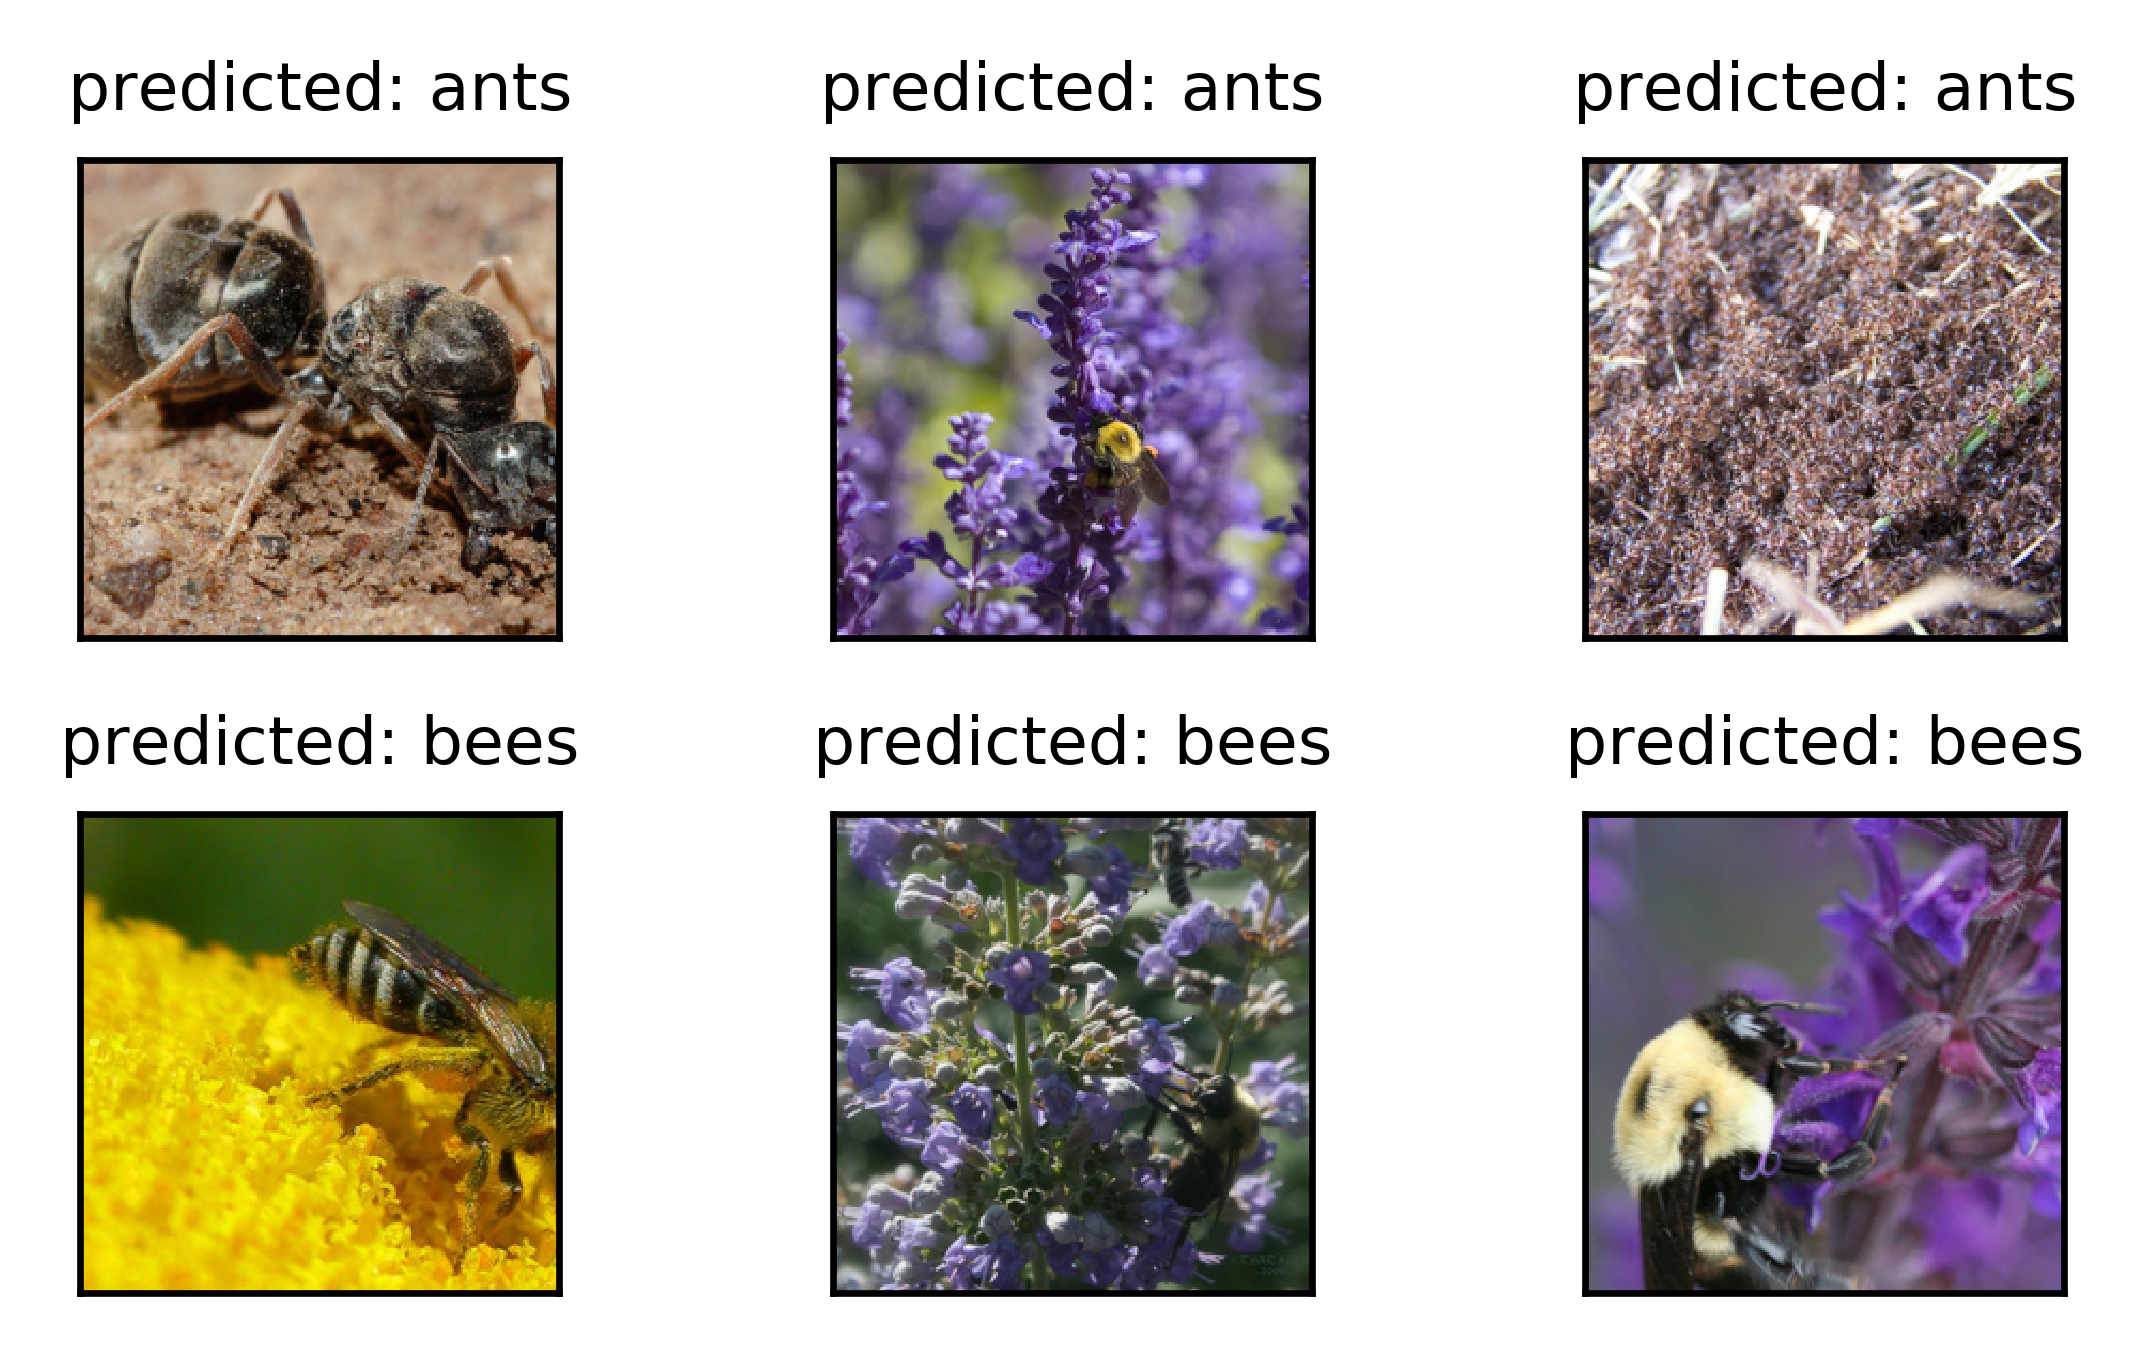

In [33]:
beatify(fig_width=4)
visualize_model(model_best)

### 2.1.3 Load and define models for transfer learning: ConvNet as fixed feature extractor


Here, we need to freeze all the network except the final layer. We need to set requires_grad == False to freeze the parameters so that the gradients are not computed in backward().

You can read more about this in the documentation here <http://pytorch.org/docs/notes/autograd.html#excluding-subgraphs-from-backward>__.

In [37]:
model_resnet18_conv = models.resnet18(pretrained=True)
for param in model_resnet18_conv.parameters():
    param.requires_grad = False

Parameters of newly constructed modules have requires_grad=True by default

In [38]:
num_feature = model_resnet18_conv.fc.in_features
model_resnet18_conv.fc = nn.Linear(num_feature, 2)

### 2.1.3.1 Define loss function and Optimizer

In [39]:
criterion = nn.CrossEntropyLoss()   

In [40]:
optimizer_rst18_conv = torch.optim.SGD(model_resnet18_conv.fc.parameters(), lr=0.001, momentum=0.9)

### NOTE:
Observe that only parameters of final layer are being optimized as opoosed to before.

In [43]:
#Define schedule
scheduler_lr_conv = lr_scheduler.StepLR(optimizer_rst18_conv, step_size=5)

In [44]:
#Check if Cuda is available
if torch.cuda.is_available():
    model_resnet18_conv = model_resnet18_conv.cuda()
    criterion = criterion.cuda()

### 2.1.3.1 Train model

In [45]:
model_best_conv = fit_model(model_resnet18_conv, criterion, optimizer_rst18_conv, scheduler_lr_conv, dataloaders, num_epochs=10)

Epoch 1/10
----------
train Loss: 0.7486 Acc: 0.6066
val Loss: 0.3780 Acc: 0.7974

Epoch 2/10
----------
train Loss: 0.6276 Acc: 0.7377
val Loss: 0.2089 Acc: 0.9281

Epoch 3/10
----------
train Loss: 0.5089 Acc: 0.7705
val Loss: 0.1796 Acc: 0.9412

Epoch 4/10
----------
train Loss: 0.4169 Acc: 0.8074
val Loss: 0.1618 Acc: 0.9608

Epoch 5/10
----------
train Loss: 0.4341 Acc: 0.8115
val Loss: 0.1813 Acc: 0.9477

Epoch 6/10
----------
train Loss: 0.3379 Acc: 0.8402
val Loss: 0.1888 Acc: 0.9412

Epoch 7/10
----------
train Loss: 0.4065 Acc: 0.8115
val Loss: 0.1620 Acc: 0.9608

Epoch 8/10
----------
train Loss: 0.3791 Acc: 0.8156
val Loss: 0.1716 Acc: 0.9542

Epoch 9/10
----------
train Loss: 0.3309 Acc: 0.8648
val Loss: 0.1892 Acc: 0.9477

Epoch 10/10
----------
train Loss: 0.3173 Acc: 0.8525
val Loss: 0.1556 Acc: 0.9608

Training complete in 4m 50s
Best val Acc: 0.960784


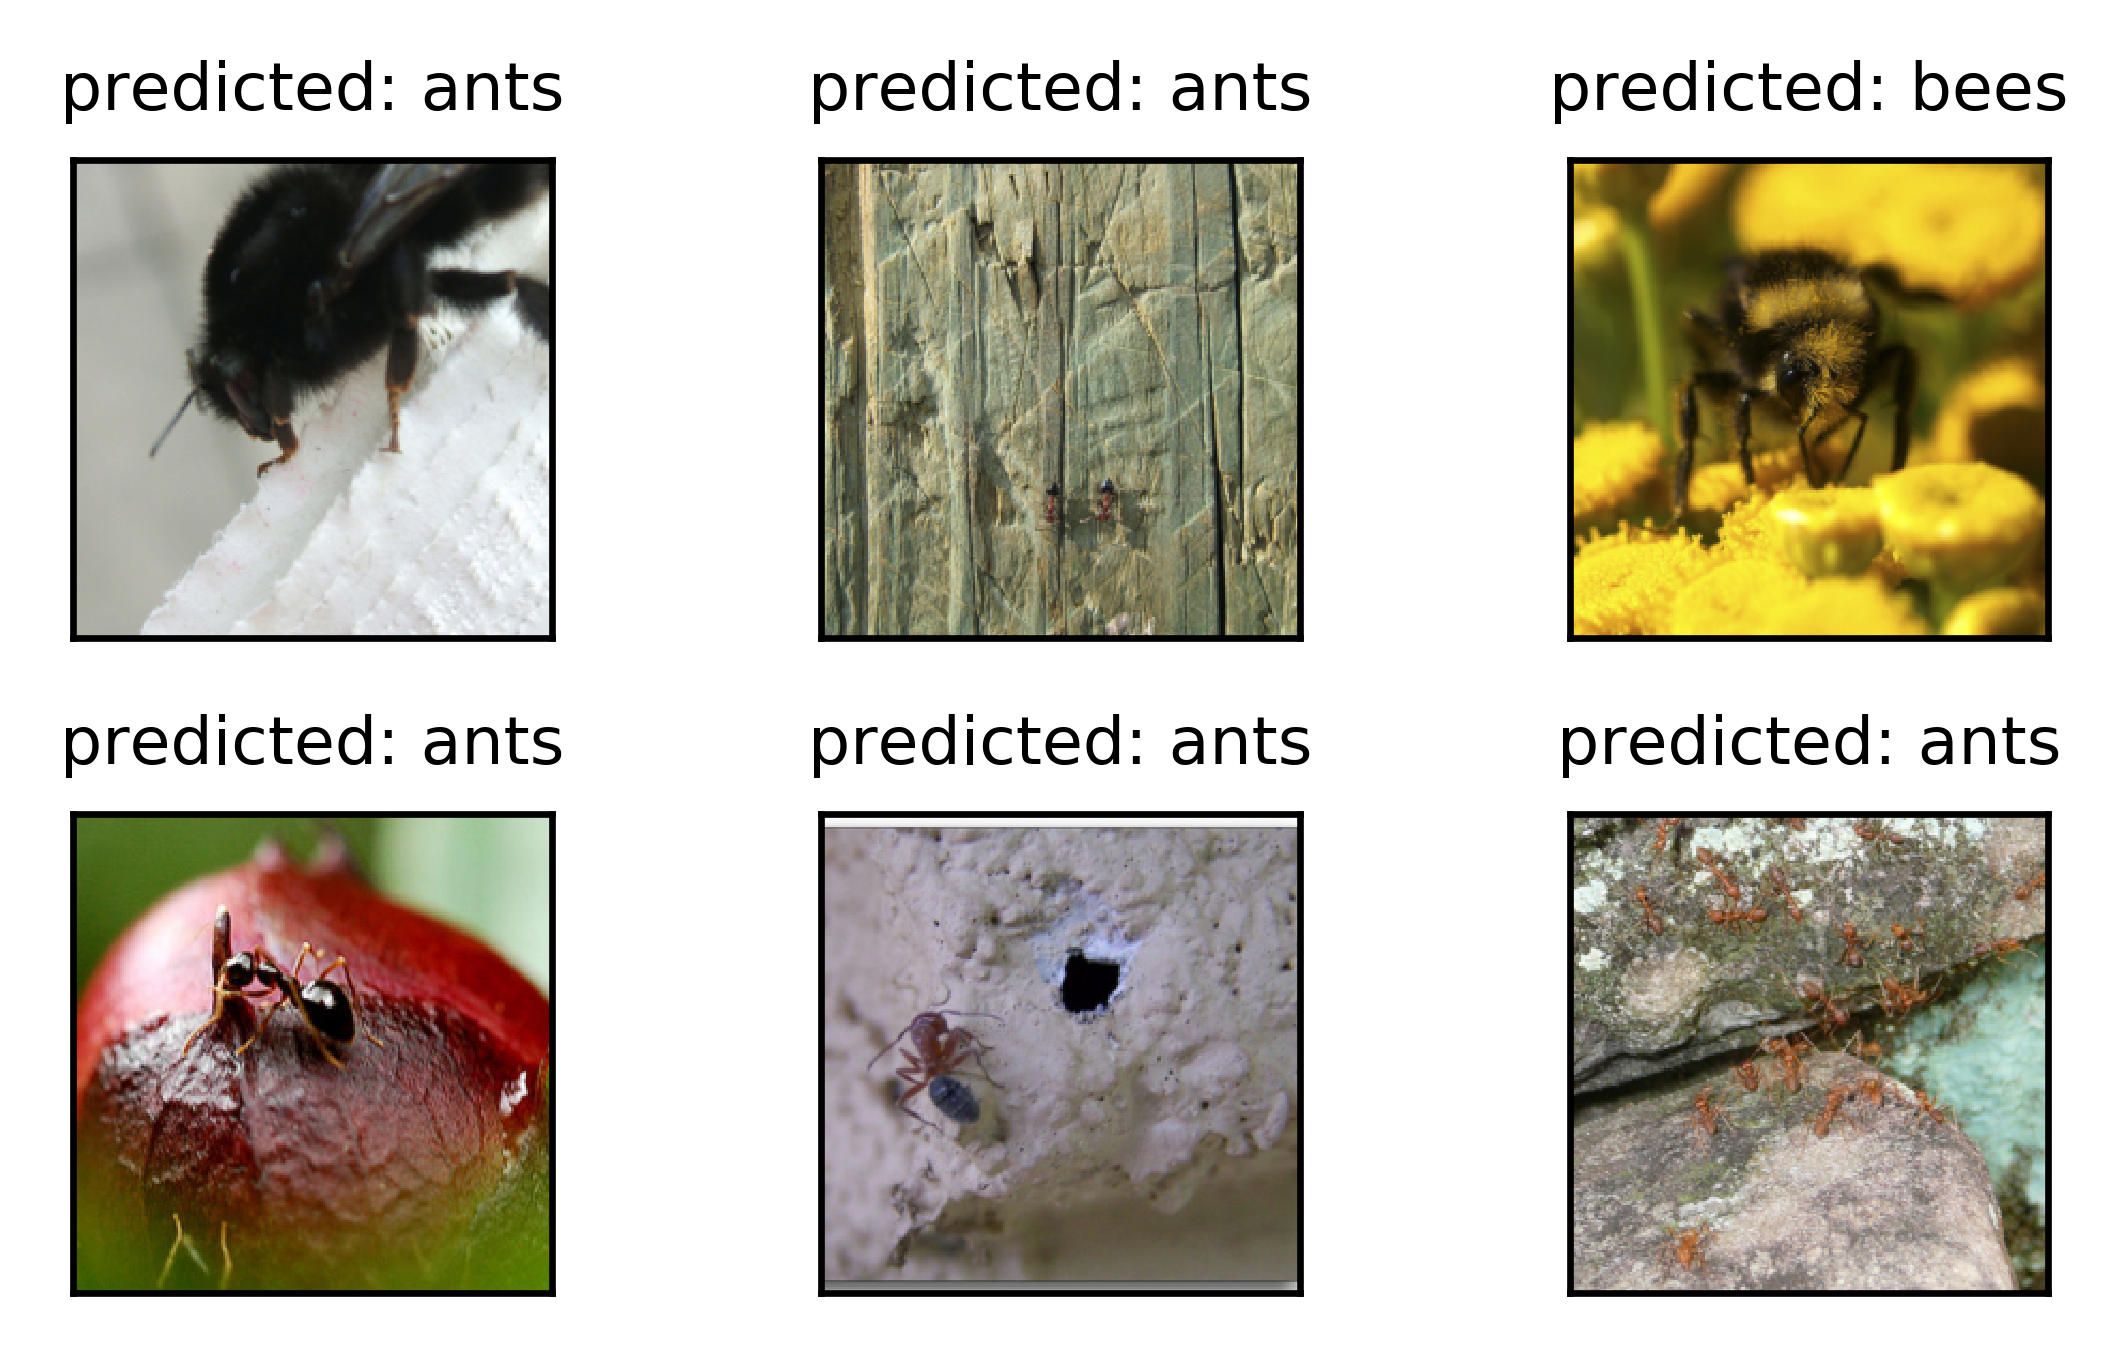

In [46]:
beatify(fig_width=4)
visualize_model(model_best)

**Questions**
1. How can you compare the two approaches above? 
2. What is the best score for each aproaches?

### 2. 2 Transfer learning 2:  Neural Style Transfer

Neural Style Transfer (NST), is the technique of recomposing images in the style of other images. It merges two images, namely, a "content" image (C) and a "style" image (S), to create a "generated" image (G). The generated image G combines the "content" of the image C with the "style" of image S.

**Learning Goal**: Understand the techniques, intuitions and math behind behind style transfer and how to build Neural Style Transfer using Pytorch.



### 2.2.1 Introduction


The principle is simple: we define two losses, one for the content image ($J_c$) and one for the style ($J_s$). $J_c$ measures how different the content is between two images, while $J_s$ measures how different the style is between two images. Then, we take a third image, the input, (e.g. a with noise), and we transform it in order to both minimize its content-loss with the content-image and its style-distance with the style-image.


NST uses a previously trained convolutional network, and builds on top of that. We will use pre-trained VGG model 

VGG model is one of the most studied Deep learning models for transfer learning is VGG. The model can be split into two kinds of logical blocks

 **Convolution blocks**: The pre-trained VGG model is trained on Image net data set over 1000 categories. The convolutional block contains multiple convolution layers. The initial layers contain low level features like lines , curves . The last convolutional layers in this block contain more complex kind of features of images like hand, leg , eyes and many more.The convolution layers exhibit 2 important properties.
 - The number of parameters required is far less compared to fully connected layer. For example a Convolution layer with $3 * 3 * 64$ size filters need only 576 parameters.
 - Convolution layers are computationally expensive and take longer to compute the output.
 
**Fully Connected Block**: This block contains FC layers with dropouts. The number of parameters to learn in FC layers are huge but takes way less time to compute.

So, we generally end up taking pre convoluted features from Convolution block of VGG model as it is and training only the last few layers of the VGG model which are generally from FC block.

### 2. 2.2 Load and Process Image

In order to simplify the implementation, let’s start by importing a style and a content image of the same dimentions. We then scale them to the desired output image size and transform them into torch tensors, ready to feed a neural network:

The pre-trained models expect input  mini-batches of 3-channel RGB images of shape (3 x H x W), where H and W are expected to be at least 224. The images have to be loaded in to a range of [0, 1] and then normalized using mean = [0.40760392, 0.45795686, 0.48501961] and std = [1, 1, 1]

In [47]:
image_size=224
transform = transforms.Compose([
                    transforms.Resize(image_size),
                    transforms.CenterCrop(image_size),
                    transforms.ToTensor(),
                    transforms.Normalize(mean=[0.40760392, 0.45795686, 0.48501961], 
                                         std=[0.229, 0.224, 0.225]),
                ])

Let define a function for load style image and apply the above transformation.

In [153]:
def image_loader(image_name):
    image = Image.open(image_name)
    image = Variable(transform(image))
    # fake batch dimension required to fit network's input dimensions
    image = image.unsqueeze(0)
    return image

In [191]:
def recover_image(img):
    return (
        (
            img *
            np.array([0.229, 0.224, 0.225]).reshape((1, 3, 1, 1)) +
            np.array([0.485, 0.456, 0.406]).reshape((1, 3, 1, 1))
        ).transpose(0, 2, 3, 1) *
        255.
    ).clip(0, 255).astype(np.uint8)

In [196]:
def image_plot(image, title=None):
    image = recover_image(image.cpu().data.numpy())[0]
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.axis('off')

### Prepare Images

In [156]:
content_img = image_loader("../data/style/Tuebingen_Neckarfront.jpg")
style_img = image_loader("../data/style/vangogh_starry_night.jpg")

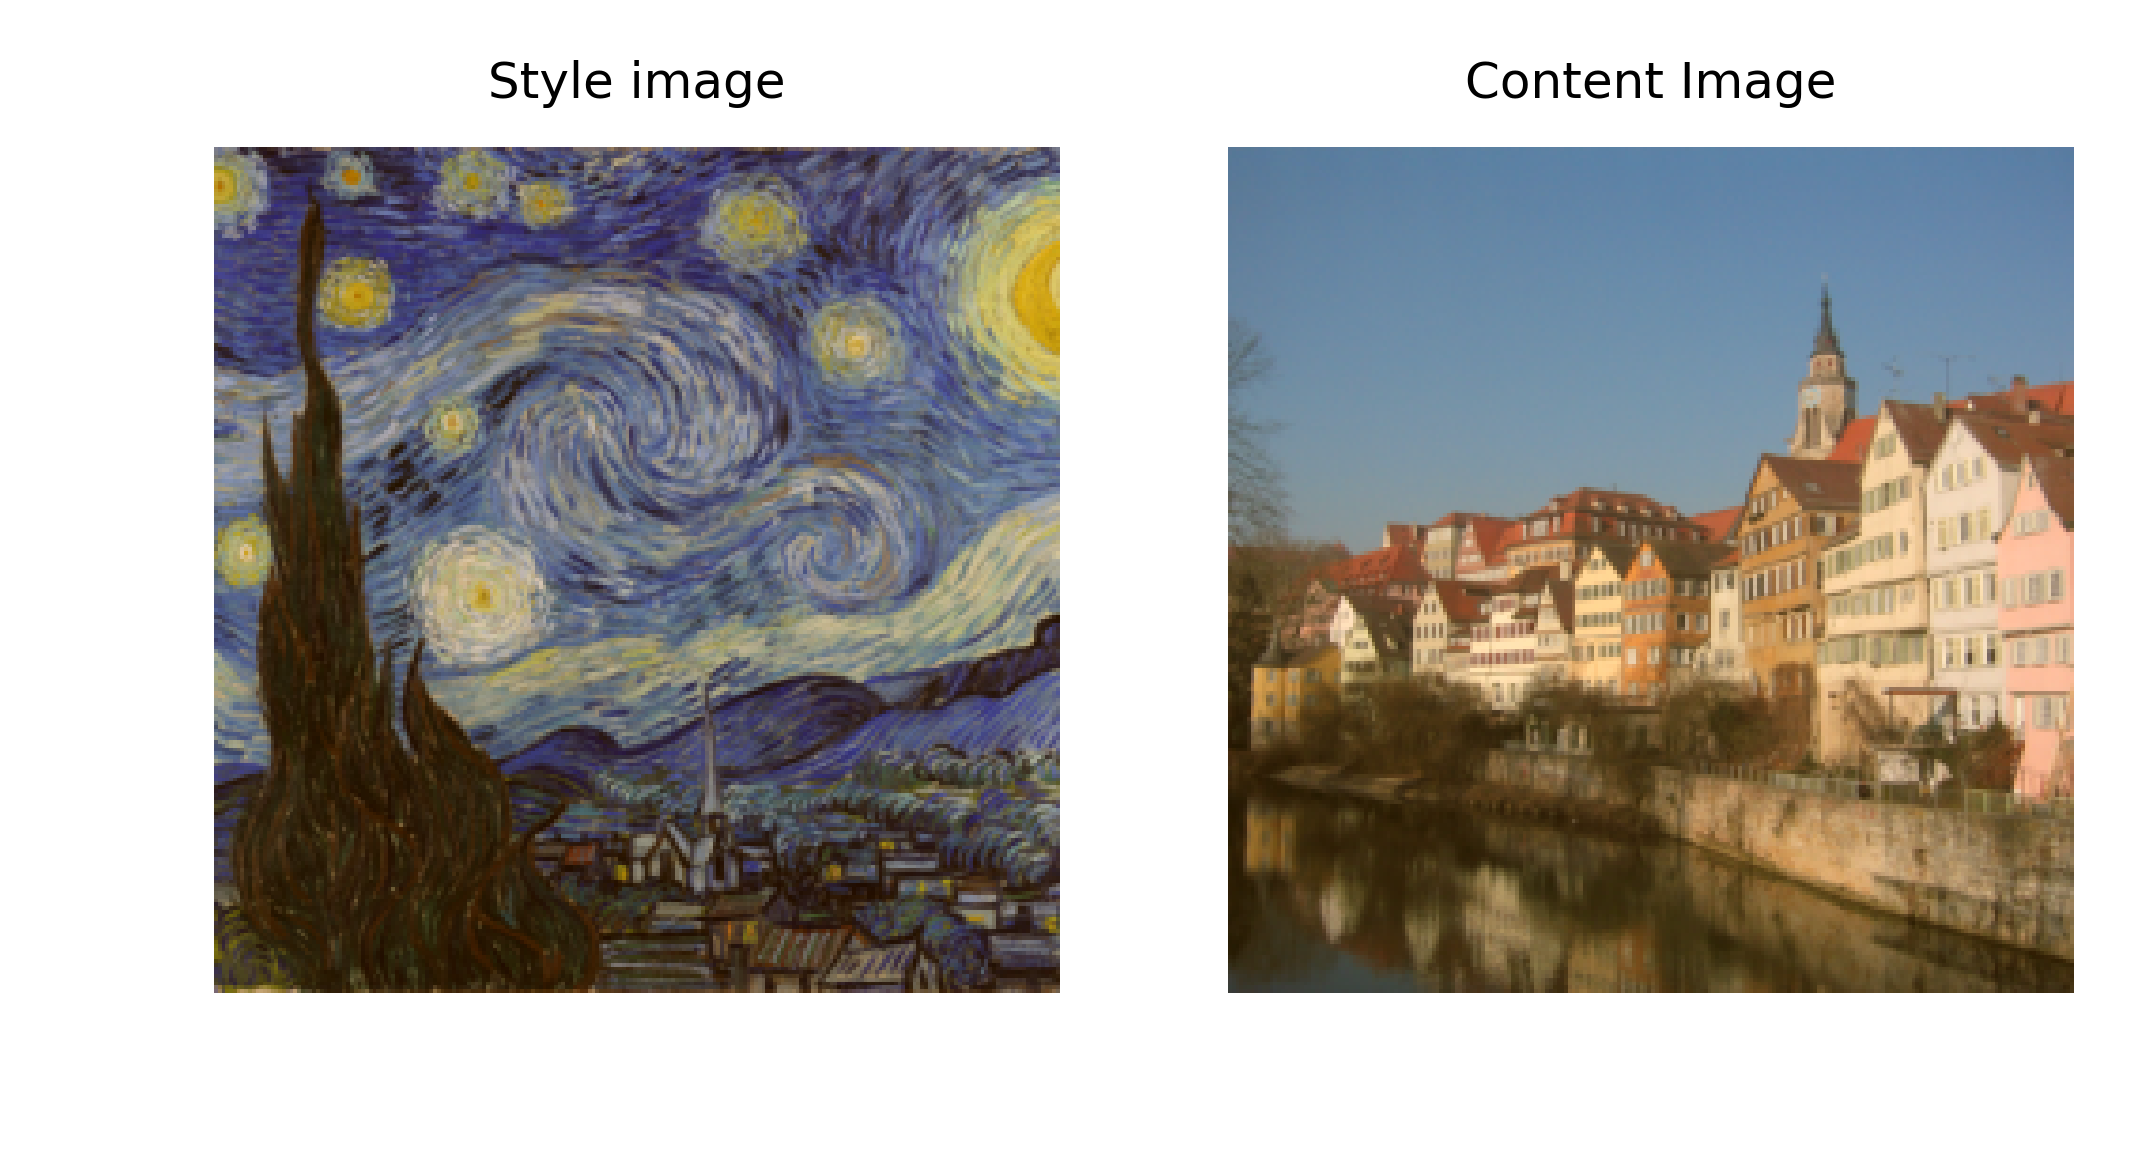

In [205]:
beatify(fig_width=4)
plt.subplot(1,2,1)
image_plot(style_img,"Style image" )
plt.subplot(1,2,2)
image_plot(content_img, title='Content Image')

### 2. 2.3 Define content and style loss

### 2.2.3.1 Content cost

Let $C_{nn}$ be a
pre-trained deep convolutional neural network and $X$ be any
image. $C_{nn}(X)$ is the network fed by $X$ (containing
feature maps at all layers). Let $F_{XL} \in C_{nn}(X)$ be the
feature maps at depth layer $L$, all vectorized and concatenated
in one single vector. We simply define the content of $X$ at layer
$L$ by $F_{XL}$. Then, if $Y$ is another image of same
the size than $X$, we define the loss of content at layer
$L$ as follow:

\begin{align}J_c^L(X,Y) = \|F_{XL} - F_{YL}\|^2 = \sum_i (F_{XL}(i) - F_{YL}(i))^2\end{align}

Where $F_{XL}(i)$ is the $i^{th}$ element of $F_{XL}$. The lossf unction $\|F_{XL} - F_{YL}\|^2$ is the Mean Square Error between the two sets of feature maps, that can be computed using a criterion `nn.MSELoss()`.



In [51]:
content_loss = nn.MSELoss()

### 2.2.3.1 Style cost
For the style loss, we need first to define a module that compute the
style matrix, also called a "Gram matrix" $G_{XL}$ given the feature maps $F_{XL}$ of the
neural network fed by $X$, at layer $L$. In linear algebra, the Gram matrix G of a set of vectors $(v_{1},\dots ,v_{n})$ is the matrix of dot products, whose entries are ${\displaystyle G_{ij} = v_{i}^T v_{j} = np.dot(v_{i}, v_{j})  }$. In other words, $G_{ij}$ compares how similar $v_i$ is to $v_j$: If they are highly similar, you would expect them to have a large dot product, and thus for $G_{ij}$ to be large.


Let
$\hat{F}_{XL}$ be the re-shaped version of $F_{XL}$ into a
$K$ x $N$ matrix, where $K$ is the number of feature
maps at layer $L$ and $N$ the lenght of any vectorized
feature map $F_{XL}^k$. The $k^{th}$ line of
$\hat{F}_{XL}$ is $F_{XL}^k$. We let you check that
$\hat{F}_{XL} \cdot \hat{F}_{XL}^T = G_{XL}$. Given that, it
becomes easy to implement our module:

In [48]:
class GramMatrix(nn.Module):
    
    def forward(self, X): # [batch,channel,height,width] -> [b,c,h*w]
        b,c,h,w = X.size()
        F = X.view(b, c, h*w)# resise F_XL into \hat F_XL
        G = torch.bmm(F, F.transpose(1,2)) 
        return G

Then, the style loss module is implemented exactly the same way than the content loss module, but we have to add the gramMatrix as a parameter:



In [49]:
class StyleLoss(nn.Module):
    
    def forward(self, X, target):
        
        out = nn.MSELoss()(GramMatrix()(X), target)
        return(out)

### 2.2.3 Load and define models for transfer learning using VGG 


Now, we have to import a pre-trained neural network. As in the paper, we
are going to use a pretrained VGG network with 19 layers (VGG19).

PyTorch's implementation of VGG is a module divided in two child
``Sequential`` modules: ``features`` (containing convolution and pooling
layers) and ``classifier`` (containing fully connected layers). We are
just interested by ``features``:

In [83]:
model_vgg = models.vgg19(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /home/ibcn079/.torch/models/vgg19-dcbb9e9d.pth
100%|██████████| 574673361/574673361 [20:54<00:00, 457967.65it/s] 


In [86]:
print(model_vgg)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (17): ReLU(

### Extract features of an image from a trained model

In [50]:
content_layers = ['conv4']
style_layers = ['conv1', 'conv2', 'conv3', 'conv4', 'conv5']

In [211]:
vgg_model = models.vgg16(pretrained=True)
if torch.cuda.is_available():
    vgg_model.cuda()
loss_network = LossNetwork(vgg_model)
loss_network.eval()

LossNetwork(
  (vgg_layers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=F

#### Define  Optimizer

In [53]:
content_loss = nn.MSELoss() 
lr = 1e-3
optimizer = torch.optim.Adam([nn.Parameter(output_image.data)], lr = 0.00001, weight_decay =0.00019)

NameError: name 'output_image' is not defined

In [220]:
#Check if Cuda is available
if torch.cuda.is_available():
    model = model.cuda()

### Train and validate model

In [ ]:
model_best_vgg = fit_model(model_vgg, criterion, optimizer_vgg, scheduler_lr_vgg, image_loaders, num_epochs=10)

## References

- [A Gentle Introduction to Transfer Learning for Deep Learning
](https://machinelearningmastery.com/transfer-learning-for-deep-learning/)
- [Transfer Learning - Machine Learning's Next Frontier](http://ruder.io/transfer-learning/)
- [Transfer](http://cs231n.github.io/transfer-learning/)
- [Transfer learning using pytorch — Part 1](https://towardsdatascience.com/transfer-learning-using-pytorch-4c3475f4495)
- [Transfer learning using pytorch — Part 2](https://towardsdatascience.com/transfer-learning-using-pytorch-part-2-9c5b18e15551)